# Singapore AirBNB Rental Prediction


## Library Imports

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from tqdm import tqdm
sns.set()


# Base Classes
from sklearn.base import BaseEstimator, TransformerMixin

# Experimental
from sklearn.experimental import enable_iterative_imputer

# Model Evaluation
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error

# Data Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.impute import MissingIndicator, SimpleImputer, IterativeImputer

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor

# Hyperparameter Tuning
from sklearn.model_selection import  validation_curve, RandomizedSearchCV

# Feature Selection
from sklearn.feature_selection import SelectFromModel, RFECV, SelectKBest, SequentialFeatureSelector, VarianceThreshold, mutual_info_regression, RFE

# Random State Instance. Using a RandomState instance sets the seed for the RNG generator. This allows for reproducible results, while still ensuring robust results (e.g. not overfitting to the random state)
random_state = np.random.RandomState(42) # also note that for cross validation, the splitter will be passed an integer while the actual estimator will be passed the random state instance, as recommended by scikit-learn documentation.

In [2]:
%matplotlib inline

## Data Ingestion

In [3]:
filepath = "listings.csv"

df = pd.read_csv(filepath)
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,50646,https://www.airbnb.com/rooms/50646,20210929043603,2021-09-29,Pleasant Room along Bukit Timah,Fully furnished bedroom with a nice view on th...,The serenity & quiet surrounding makes it an i...,https://a0.muscache.com/pictures/36342984/670d...,227796,https://www.airbnb.com/users/show/227796,...,4.94,4.72,4.50,NaN,f,1,0,1,0,0.21
1,71609,https://www.airbnb.com/rooms/71609,20210929043603,2021-09-29,Ensuite Room (Room 1 & 2) near EXPO,For 3 rooms.Book room 1&2 and room 4<br /><br ...,NaN,https://a0.muscache.com/pictures/24453191/3580...,367042,https://www.airbnb.com/users/show/367042,...,4.78,4.26,4.32,NaN,f,4,0,4,0,0.27
2,71896,https://www.airbnb.com/rooms/71896,20210929043603,2021-09-29,B&B Room 1 near Airport & EXPO,<b>The space</b><br />Vocational Stay Deluxe B...,NaN,https://a0.muscache.com/pictures/2440674/ac4f4...,367042,https://www.airbnb.com/users/show/367042,...,4.43,4.17,4.04,NaN,f,4,0,4,0,0.32
3,71903,https://www.airbnb.com/rooms/71903,20210929043603,2021-09-29,Room 2-near Airport & EXPO,"Like your own home, 24hrs access.<br /><br /><...",Quiet and view of the playground with exercise...,https://a0.muscache.com/pictures/568743/7bc623...,367042,https://www.airbnb.com/users/show/367042,...,4.64,4.51,4.38,NaN,f,4,0,4,0,0.64
4,275343,https://www.airbnb.com/rooms/275343,20210929043603,2021-09-29,"Conveniently located City Room!(1,2,3,4,5,6,7,8)",Awesome location and host <br />Room near INSE...,NaN,https://a0.muscache.com/pictures/11979330/9bbd...,1439258,https://www.airbnb.com/users/show/1439258,...,4.47,4.53,4.59,NaN,f,50,1,49,0,0.19


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4221 non-null   int64  
 1   listing_url                                   4221 non-null   object 
 2   scrape_id                                     4221 non-null   int64  
 3   last_scraped                                  4221 non-null   object 
 4   name                                          4221 non-null   object 
 5   description                                   4084 non-null   object 
 6   neighborhood_overview                         2766 non-null   object 
 7   picture_url                                   4221 non-null   object 
 8   host_id                                       4221 non-null   int64  
 9   host_url                                      4221 non-null   o

## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            4221 non-null   int64  
 1   listing_url                                   4221 non-null   object 
 2   scrape_id                                     4221 non-null   int64  
 3   last_scraped                                  4221 non-null   object 
 4   name                                          4221 non-null   object 
 5   description                                   4084 non-null   object 
 6   neighborhood_overview                         2766 non-null   object 
 7   picture_url                                   4221 non-null   object 
 8   host_id                                       4221 non-null   int64  
 9   host_url                                      4221 non-null   o

In [6]:
filtered_columns = [
                    "neighbourhood_cleansed",
                    "room_type",
                    "bathrooms_text",
                    "bedrooms",
                    "beds",
                    "accommodates", 
                    "amenities",
                    "minimum_nights",
                    "availability_365",
                    "review_scores_rating",
                    "price"
]



In [7]:
air_df = df[filtered_columns]

In [8]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4221 entries, 0 to 4220
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   neighbourhood_cleansed  4221 non-null   object 
 1   room_type               4221 non-null   object 
 2   bathrooms_text          4192 non-null   object 
 3   bedrooms                3770 non-null   float64
 4   beds                    4143 non-null   float64
 5   accommodates            4221 non-null   int64  
 6   amenities               4221 non-null   object 
 7   minimum_nights          4221 non-null   int64  
 8   availability_365        4221 non-null   int64  
 9   review_scores_rating    2410 non-null   float64
 10  price                   4221 non-null   object 
dtypes: float64(3), int64(3), object(5)
memory usage: 362.9+ KB


### Remove Price Outlier

In [9]:
air_df = df[filtered_columns]
air_df["price"] = air_df["price"].str[1:-3].str.replace(",", "").astype(float)

/tmp/ipykernel_11983/3605259680.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df["price"] = air_df["price"].str[1:-3].str.replace(",", "").astype(float)


In [10]:
air_df.describe()

,bedrooms,beds,accommodates,minimum_nights,availability_365,review_scores_rating,price
count,3770.000000,4143.000000,4221.000000,4221.000000,4221.000000,2410.000000,4221.000000
mean,1.314854,1.811007,2.825160,30.097370,255.043118,4.478261,170.167733
std,0.677358,2.500749,2.223046,61.516909,131.092824,0.885672,345.224111
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,2.000000,2.000000,124.000000,4.380000,64.000000
50%,1.000000,1.000000,2.000000,7.000000,335.000000,4.750000,110.000000
75%,1.000000,2.000000,4.000000,30.000000,364.000000,5.000000,180.000000
max,8.000000,58.000000,16.000000,1000.000000,365.000000,5.000000,10286.000000


We note the presense of extreme outliers in the price. To ensure our model not affected by these extreme outliers, we will remove them, since they do not consititute a significant part of the data.

In [11]:

def mark_extreme_outlier(df, var):
  col = df[var].apply(np.log1p)
  Q3 = col.quantile(0.75)
  Q1 = col.quantile(0.25)
  IQR = Q3 - Q1
  UpperFence = Q3 + 1.5 * IQR
  LowerFence = Q1 - 1.5 * IQR
  mask = (col > UpperFence) | (col < LowerFence)
  return mask.values
air_df["drop"] = mark_extreme_outlier(air_df, "price")
air_df = air_df[air_df["drop"] == 0]
air_df.reset_index(inplace=True)
air_df.drop("drop", axis=1, inplace=True)

/tmp/ipykernel_11983/2026873981.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df["drop"] = mark_extreme_outlier(air_df, "price")


In [12]:
air_df["price"].describe()

count    4165.000000
mean      143.487155
std       121.884970
min        13.000000
25%        64.000000
50%       109.000000
75%       176.000000
max       837.000000
Name: price, dtype: float64

### Processing Bathrooms

In [13]:
air_df["bathrooms_text"].unique()

array(['1 bath', '1 private bath', 'Shared half-bath', nan,
       '1.5 shared baths', '1 shared bath', '0 baths', '2 shared baths',
       '4 shared baths', '2 baths', 'Private half-bath', '3 baths',
       '2.5 baths', '4 baths', '3 shared baths', '1.5 baths', '8 baths',
       '0 shared baths', 'Half-bath', '3.5 baths', '2.5 shared baths',
       '5 baths', '6 baths', '5 shared baths', '7.5 shared baths',
       '7 shared baths', '8 shared baths', '6 shared baths',
       '12.5 shared baths', '4.5 shared baths', '4.5 baths',
       '8.5 shared baths', '8.5 baths', '9 shared baths', '10 baths',
       '10 shared baths', '21 shared baths', '3.5 shared baths',
       '16 shared baths', '16 baths', '13 baths', '12 shared baths',
       '12 baths', '13 shared baths', '5.5 shared baths'], dtype=object)

In [14]:
air_df["bathrooms_cleaned"] = air_df["bathrooms_text"].str.lower().str.replace("half-bath", "0.5").str.strip("bath shared private").astype(float)

In [15]:
air_df["bathrooms_cleaned"].unique()

array([ 1. ,  0.5,  nan,  1.5,  0. ,  2. ,  4. ,  3. ,  2.5,  8. ,  3.5,
        5. ,  6. ,  7.5,  7. , 12.5,  4.5,  8.5,  9. , 10. , 21. , 16. ,
       13. , 12. ,  5.5])

In [16]:
air_df = air_df.drop("bathrooms_text", axis=1)

In [17]:
air_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4165 entries, 0 to 4164
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   4165 non-null   int64  
 1   neighbourhood_cleansed  4165 non-null   object 
 2   room_type               4165 non-null   object 
 3   bedrooms                3725 non-null   float64
 4   beds                    4090 non-null   float64
 5   accommodates            4165 non-null   int64  
 6   amenities               4165 non-null   object 
 7   minimum_nights          4165 non-null   int64  
 8   availability_365        4165 non-null   int64  
 9   review_scores_rating    2392 non-null   float64
 10  price                   4165 non-null   float64
 11  bathrooms_cleaned       4137 non-null   float64
dtypes: float64(5), int64(4), object(3)
memory usage: 390.6+ KB


### Amenities

In [18]:
air_df["amenities"]

0       ["Pool", "Essentials", "Cable TV", "Wifi", "Lo...
1       ["Essentials", "Hair dryer", "Iron", "Hot tub"...
2       ["Essentials", "Hair dryer", "Coffee maker", "...
3       ["Lock on bedroom door", "Essentials", "Hair d...
4       ["Lock on bedroom door", "Essentials", "Hair d...
                              ...                        
4160    ["Pool", "Lock on bedroom door", "Washer", "TV...
4161    ["Dedicated workspace", "Free parking on premi...
4162    ["Essentials", "Hair dryer", "Iron", "TV", "Wi...
4163    ["Essentials", "Hair dryer", "Iron", "Carbon m...
4164    ["Bed linens", "Essentials", "Extra pillows an...
Name: amenities, Length: 4165, dtype: object

In [19]:
amenities = air_df["amenities"].str.strip('[]').str.replace('"', "").str.replace(" ", "").str.lower().str.split(",")
amenities

0       [pool, essentials, cabletv, wifi, longtermstay...
1       [essentials, hairdryer, iron, hottub, privatee...
2       [essentials, hairdryer, coffeemaker, paidparki...
3       [lockonbedroomdoor, essentials, hairdryer, air...
4       [lockonbedroomdoor, essentials, hairdryer, air...
                              ...                        
4160    [pool, lockonbedroomdoor, washer, tv, longterm...
4161    [dedicatedworkspace, freeparkingonpremises, wa...
4162    [essentials, hairdryer, iron, tv, wifi, longte...
4163    [essentials, hairdryer, iron, carbonmonoxideal...
4164    [bedlinens, essentials, extrapillowsandblanket...
Name: amenities, Length: 4165, dtype: object

In [20]:
amenities.explode().value_counts()[:20]

longtermstaysallowed    4090
airconditioning         4033
wifi                    4023
essentials              3569
washer                  3509
hangers                 3374
kitchen                 3271
iron                    3179
dedicatedworkspace      3132
hairdryer               2874
dryer                   2801
hotwater                2657
shampoo                 2496
tv                      2165
refrigerator            2124
elevator                2097
pool                    2001
microwave               1952
dishesandsilverware     1899
bedlinens               1874
Name: amenities, dtype: int64

In [21]:
mask = amenities.apply(lambda x : 'wifi' in x)
amenities[mask]

0       [pool, essentials, cabletv, wifi, longtermstay...
1       [essentials, hairdryer, iron, hottub, privatee...
2       [essentials, hairdryer, coffeemaker, paidparki...
3       [lockonbedroomdoor, essentials, hairdryer, air...
4       [lockonbedroomdoor, essentials, hairdryer, air...
                              ...                        
4160    [pool, lockonbedroomdoor, washer, tv, longterm...
4161    [dedicatedworkspace, freeparkingonpremises, wa...
4162    [essentials, hairdryer, iron, tv, wifi, longte...
4163    [essentials, hairdryer, iron, carbonmonoxideal...
4164    [bedlinens, essentials, extrapillowsandblanket...
Name: amenities, Length: 4023, dtype: object

In [22]:
key_amenities = [
                #  "essentials",
                #  "washer",
                #  "kitchen",
                #  "dedicatedworkspace",
                 "elevator",
                 "pool",
                 "wifi"
]

In [23]:
one_hot_amenities = {}
for amenity in key_amenities:
  one_hot_amenities[amenity] =  amenities.apply(lambda x : amenity in x).astype(int)
one_hot_amenities

{'elevator': 0       1
 1       0
 2       0
 3       0
 4       1
        ..
 4160    0
 4161    0
 4162    0
 4163    1
 4164    1
 Name: amenities, Length: 4165, dtype: int64,
 'pool': 0       1
 1       0
 2       0
 3       0
 4       0
        ..
 4160    1
 4161    0
 4162    0
 4163    1
 4164    1
 Name: amenities, Length: 4165, dtype: int64,
 'wifi': 0       1
 1       1
 2       1
 3       1
 4       1
        ..
 4160    1
 4161    1
 4162    1
 4163    1
 4164    1
 Name: amenities, Length: 4165, dtype: int64}

In [24]:
amenities_df = pd.DataFrame(one_hot_amenities)

In [25]:
air_df_amenities = pd.concat([air_df, amenities_df], axis=1)
air_df_amenities

,index,neighbourhood_cleansed,room_type,bedrooms,beds,accommodates,amenities,minimum_nights,availability_365,review_scores_rating,price,bathrooms_cleaned,elevator,pool,wifi
0,0,Bukit Timah,Private room,1.0,1.0,2,"[""Pool"", ""Essentials"", ""Cable TV"", ""Wifi"", ""Lo...",90,364,4.56,80.0,1.0,1,1,1
1,1,Tampines,Private room,2.0,3.0,6,"[""Essentials"", ""Hair dryer"", ""Iron"", ""Hot tub""...",90,365,4.44,178.0,1.0,0,0,1
2,2,Tampines,Private room,1.0,1.0,3,"[""Essentials"", ""Hair dryer"", ""Coffee maker"", ""...",90,365,4.16,81.0,0.5,0,0,1
3,3,Tampines,Private room,1.0,2.0,3,"[""Lock on bedroom door"", ""Essentials"", ""Hair d...",90,365,4.42,81.0,0.5,0,0,1
4,4,Bukit Merah,Private room,1.0,1.0,1,"[""Lock on bedroom door"", ""Essentials"", ""Hair d...",14,364,4.39,52.0,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4160,4216,Singapore River,Private room,1.0,1.0,2,"[""Pool"", ""Lock on bedroom door"", ""Washer"", ""TV...",90,90,NaN,68.0,1.0,0,1,1
4161,4217,Bukit Merah,Entire home/apt,1.0,1.0,2,"[""Dedicated workspace"", ""Free parking on premi...",90,105,NaN,150.0,1.0,0,0,1
4162,4218,Marine Parade,Entire home/apt,NaN,1.0,2,"[""Essentials"", ""Hair dryer"", ""Iron"", ""TV"", ""Wi...",14,365,NaN,100.0,1.0,0,0,1
4163,4219,Central Water Catchment,Entire home/apt,2.0,2.0,5,"[""Essentials"", ""Hair dryer"", ""Iron"", ""Carbon m...",1,90,NaN,151.0,1.0,1,1,1


In [26]:
# air_df_amenities = air_df_amenities[["price", "neighbourhood_cleansed", "room_type", "accommodates", "beds", "bedrooms", "bathrooms_cleaned", "minimum_nights", "availability_365", "review_scores_rating"] + key_amenities]
air_df_amenities = air_df_amenities[["price", "neighbourhood_cleansed", "room_type", "accommodates", "beds", "bathrooms_cleaned", "minimum_nights"] + key_amenities]

<AxesSubplot:>

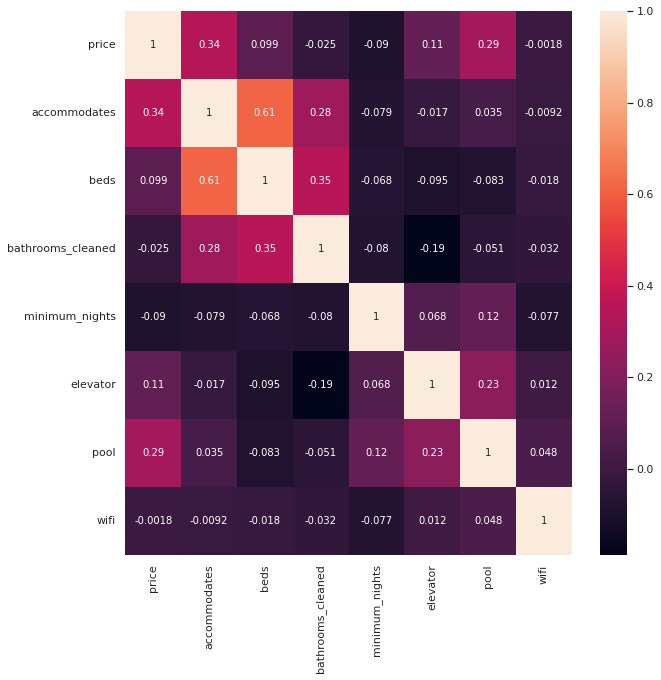

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(air_df_amenities.corr(), annot=True)

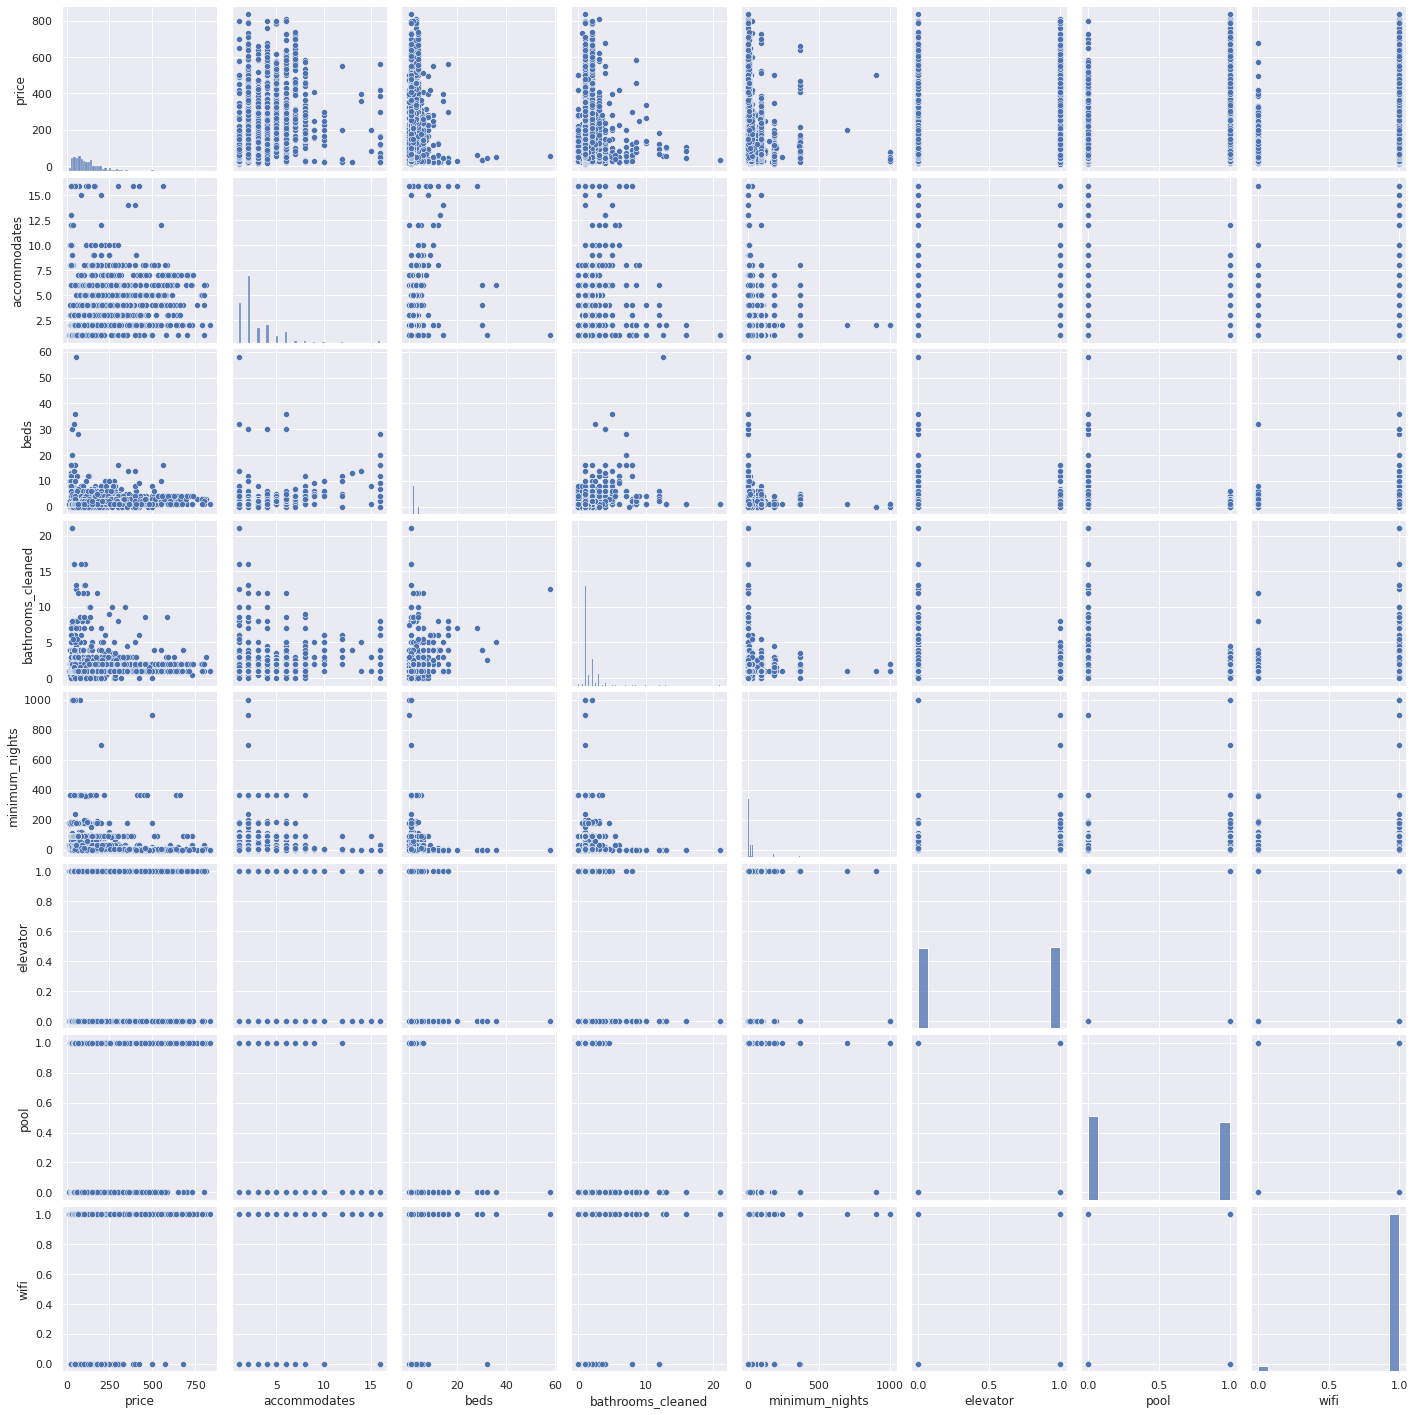

In [28]:
sns.pairplot(air_df_amenities)

## Data Split

In [29]:
X = air_df_amenities.drop(columns="price")
y = air_df_amenities["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=random_state)

In [30]:
X_train

,neighbourhood_cleansed,room_type,accommodates,beds,bathrooms_cleaned,minimum_nights,elevator,pool,wifi
2889,Tanglin,Entire home/apt,2,1.0,1.0,3,0,1,1
729,Kallang,Entire home/apt,6,1.0,1.5,1,1,1,1
1164,Kallang,Private room,1,1.0,3.0,18,0,1,1
1480,Bukit Merah,Private room,1,1.0,1.0,90,0,0,1
4089,Rochor,Private room,2,1.0,1.0,2,0,0,1
...,...,...,...,...,...,...,...,...,...
3444,Novena,Private room,1,1.0,1.0,81,0,0,1
466,Marine Parade,Private room,2,1.0,1.0,2,1,1,1
3092,Rochor,Entire home/apt,2,1.0,2.0,1,0,0,1
3772,Kallang,Private room,1,1.0,3.0,28,0,1,1


## Data Preprocessing Pipeline

In [31]:
# numerical_features = ["accommodates", "beds", "bedrooms", "bathrooms_cleaned", "minimum_nights", "availability_365", "review_scores_rating"]
numerical_features = ["accommodates", "beds", "bathrooms_cleaned", "minimum_nights"]
categorical_not_encoded = ["neighbourhood_cleansed", "room_type"]
remainder = [x for x in X_train.columns if (x not in numerical_features and x not in categorical_not_encoded)]
ColumnTransformer(
    [
     ("Scaling", StandardScaler)
    ]
)
scale_impute = Pipeline([
                         ("Scaling", PowerTransformer()),
                         ("Impute Numerical", IterativeImputer(random_state=random_state, initial_strategy="median"))
])

# data_preprocess = Pipeline(
#     [("Standardize and OHE", ColumnTransformer(
#         [
#          ("Scaling and Impute", scale_impute, numerical_features),
#          ("One Hot Encode and Impute", ohe_impute, categorical_not_encoded)
#         ]
#     , remainder="passthrough")),
#      ("To Dense Array", FunctionTransformer(lambda x : x.todense(), accept_sparse=True))
#     ]
# )

data_preprocess = Pipeline(
    [("Imputation and Scaling", ColumnTransformer([
                                                  ("Scaling and Impute Numerical", scale_impute, numerical_features),
                                                  ("Impute Categorical", SimpleImputer(strategy="most_frequent"), categorical_not_encoded)
    ], remainder="passthrough")),
    ("To DataFrame", FunctionTransformer(func=pd.DataFrame, kw_args={
    "columns" : numerical_features + categorical_not_encoded + remainder
})),
    ("OHE", ColumnTransformer(
        [
         ("OHE", OneHotEncoder(handle_unknown="ignore"), categorical_not_encoded)
        ]
    , remainder="passthrough"))]
)
X_train_processed = data_preprocess.fit_transform(X_train)
feature_names = data_preprocess[-1].get_feature_names_out(numerical_features + categorical_not_encoded + remainder) 

### ML Pipeline

In [32]:
def plot_learning_curve(model, X, y, scoring, cv = KFold(shuffle=True, random_state = 42), train_sizes = np.linspace(.1, 1.0, 5)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv = cv, n_jobs = -1, train_sizes = train_sizes, scoring=scoring)
  scores = pd.DataFrame({
      "Train Sizes" : np.tile(train_sizes, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Train Sizes"])
  sns.lineplot(data=scores, x="Train Sizes", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Learning Curve of {model_name}")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel("Train Sizes")
  return fig

def plot_validation_curve(model, X, y, param_name, param_range, scoring="neg_mean_absolute_error", cv=KFold(shuffle=True, random_state = 42)):
  try:
    model_name = type(model[-1]).__name__ 
  except:
    model_name = type(model).__name__
  fig, ax = plt.subplots(figsize=(10, 8))
  train_scores, test_scores = validation_curve(model, X, y, param_name = param_name, param_range = param_range, scoring=scoring, n_jobs = -1)
  scores = pd.DataFrame({
      "Param Range" : np.tile(param_range, train_scores.shape[1]),
      "Train Scores" : train_scores.flatten(),
      "Test Scores" : test_scores.flatten()
  }).melt(value_vars=["Train Scores", "Test Scores"], var_name="Score Type", value_name="Scores", id_vars=["Param Range"])
  
  sns.lineplot(data=scores, x="Param Range", y="Scores", hue="Score Type", ax = ax)
  ax.set_title(f"Validation Curve of {model_name} ({param_name})")
  ax.set_ylabel(f"{scoring}")
  ax.set_xlabel(f"{param_name}")
  return fig

In [33]:
def evaluate_candidate_model(reg, X, y, metrics = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "neg_root_mean_squared_error"], cv = KFold(n_splits = 5, shuffle = True, random_state=42), model_name = None, history = pd.DataFrame(), return_estimator = False, return_learning_curve = True):
    model_name = model_name if model_name is not None else type(reg).__name__
    single_metric = type(metrics) in { str, callable }
    scores = cross_validate(reg, X, y, cv = cv, scoring = metrics, return_train_score = True, return_estimator = return_estimator, n_jobs= -1)
    if return_estimator:
        best_estimator = scores["estimator"][np.argmax(scores["test_neg_mean_absolute_error"])]
        del scores["estimator"]
    scores = pd.DataFrame(scores).describe().iloc[1:3, 2:].round(5) # Get Summarized Cross Val Scores
    his_snapshot = scores.iloc[0, :]
    his_snapshot["Standard Error of MAE"] = scores["test_neg_mean_absolute_error"].iloc[1] / np.sqrt(cv.get_n_splits())
    his_snapshot["Performance Gap"] = his_snapshot["train_neg_mean_absolute_error"] - his_snapshot["test_neg_mean_absolute_error"]
    his_snapshot.rename(index=model_name, inplace=True)
    history = history.append(his_snapshot)
    if return_learning_curve:
        lr = plot_learning_curve(reg, X, y, scoring = metrics[0], cv = cv)
    return scores, history, lr if return_learning_curve else None, best_estimator if return_estimator else None

### Linear Regression

In [66]:
lr = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
     ("Linear Regression", TransformedTargetRegressor(LinearRegression(), func=np.log1p, inverse_func=np.expm1))
    ]
)

In [67]:
scores, history, lc, _ = evaluate_candidate_model(lr, X_train, y_train, model_name="Linear Regression")
display(scores)

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-51.48305,-50.44314,-0.38575,-0.37580,-90.16673,-89.17917
std,2.97042,0.80278,0.02149,0.00392,6.33349,1.50649


### RandomForests

In [68]:
rf = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
     ("Model", TransformedTargetRegressor(RandomForestRegressor(random_state=random_state), func=np.log1p, inverse_func=np.expm1))
    ]
)

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-39.15845,-19.61922,-0.28737,-0.13481,-75.78451,-42.53865
std,1.94548,0.35287,0.01196,0.00127,5.22752,1.26760


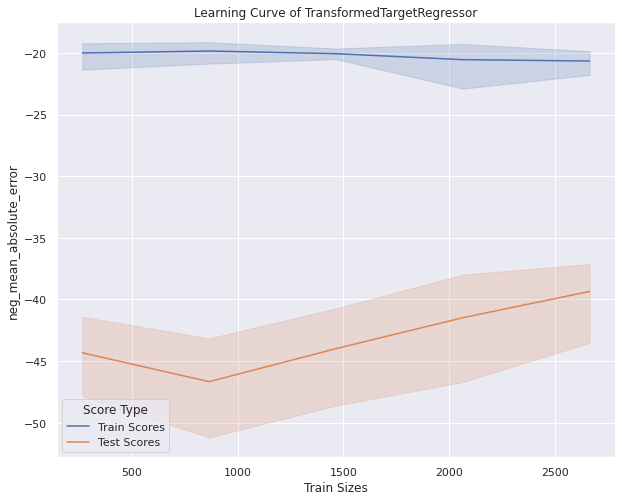

In [69]:
scores, history, lc, _ = evaluate_candidate_model(rf, X_train, y_train, model_name="Random Forests", history=history)
display(scores)
lc

### Extra Trees

In [70]:
et = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
     ("Model", TransformedTargetRegressor(ExtraTreesRegressor(random_state=random_state), func=np.log1p, inverse_func=np.expm1))
    ]
)

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-39.13101,-7.80818,-0.30319,-0.06468,-77.68204,-24.28639
std,1.98414,0.19855,0.02037,0.00096,4.87599,1.54847


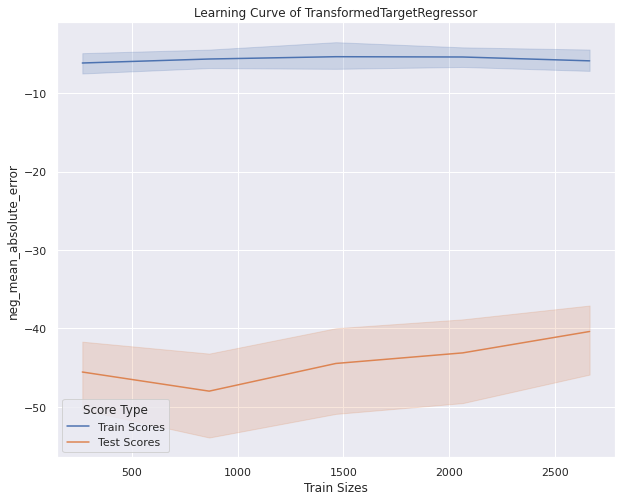

In [71]:
scores, history, lc, _ = evaluate_candidate_model(et, X_train, y_train, model_name="Extra Trees", history=history)
display(scores)
lc

### Gradient Boosting

In [72]:
hist_gbm = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
     ("To Dense", FunctionTransformer(lambda x : x.todense())),
     ("Model", TransformedTargetRegressor(HistGradientBoostingRegressor(random_state=random_state), func=np.log1p, inverse_func=np.expm1))
    ]
)

/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/utils/validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more 

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-41.58406,-34.25997,-0.30164,-0.24382,-76.74245,-65.55671
std,2.16958,0.55159,0.01634,0.00179,6.67396,1.78802


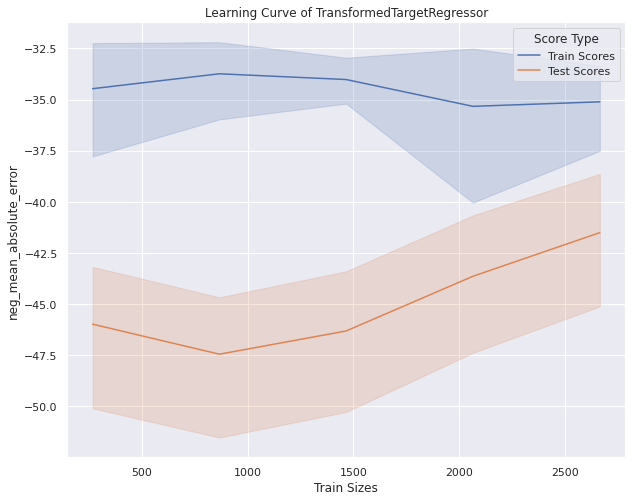

In [73]:
scores, history, lc, _ = evaluate_candidate_model(hist_gbm, X_train, y_train, model_name="hist_gbm", history=history)
display(scores)
lc

In [74]:
gb = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
    #  ("To Dense", FunctionTransformer(lambda x : x.todense())),
     ("Model", TransformedTargetRegressor(GradientBoostingRegressor(random_state=random_state), func=np.log1p, inverse_func=np.exp))
    ]
)
scores, history, lc, _ = evaluate_candidate_model(gb, X_train, y_train, model_name="gb", history=history)
display(scores)

/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:137: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/compose/_target.py:181: UserWarning: The provided functions or transformer are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'
  warnings.warn(
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/preprocessing/_function_transformer.py:137: UserWarning: The provided functions are not strictly inverse of each other. If you are sure you want to proceed regardless, set 'check_inverse=False'.
  warnings.warn(
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-pac

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-45.46784,-42.65202,-0.33704,-0.31141,-80.80946,-76.14758
std,2.71293,0.43498,0.01113,0.00180,6.40060,0.95358


In [75]:
history

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,Standard Error of MAE,Performance Gap
Linear Regression,-51.48305,-50.44314,-0.38575,-0.37580,-90.16673,-89.17917,1.328412,1.03991
Random Forests,-39.15845,-19.61922,-0.28737,-0.13481,-75.78451,-42.53865,0.870045,19.53923
Extra Trees,-39.13101,-7.80818,-0.30319,-0.06468,-77.68204,-24.28639,0.887334,31.32283
hist_gbm,-41.58406,-34.25997,-0.30164,-0.24382,-76.74245,-65.55671,0.970266,7.32409
gb,-45.46784,-42.65202,-0.33704,-0.31141,-80.80946,-76.14758,1.213259,2.81582


## Hyperparameter Tuning

In [34]:
reg_rf = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
     ("Model", TransformedTargetRegressor(RandomForestRegressor(random_state=random_state), func=np.log1p, inverse_func=np.expm1))
    ]
)

In [36]:
param_grid = {
    "Model__regressor__n_estimators" : [100, 150, 200, 250, 300],
    "Model__regressor__max_depth" : [None, 4, 5, 6, 7, 8, 9, 10, 15],
    "Model__regressor__min_samples_leaf" : [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
}
rf_random_search = RandomizedSearchCV(reg_rf, param_grid, scoring="neg_mean_absolute_error", n_iter=40, n_jobs=-1, random_state=random_state)

/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `_pairwise` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `_pairwise` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/home/tiencheng/GitLab/ca1-daaa2b01-2012072-ohtiencheng/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `_pairwise` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


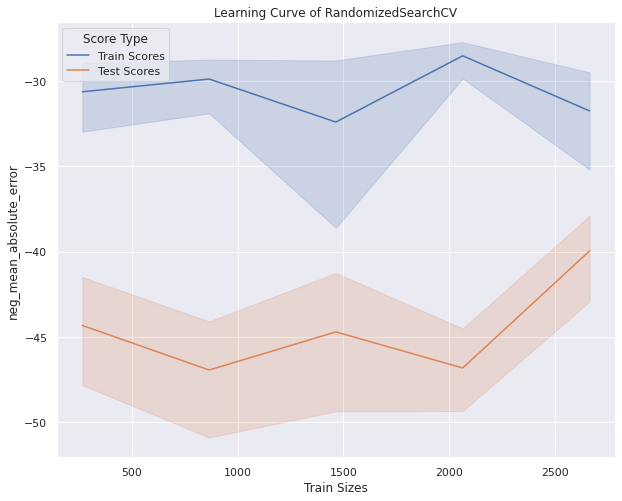

In [38]:
scores, history, lr, best_estimator_rf = evaluate_candidate_model(rf_random_search, X_train, y_train, model_name="RF (Hyperparameter Search - Random)")

In [39]:
scores

,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error
mean,-40.93508,-28.89708,-0.29373,-0.20381,-77.99715,-58.30059
std,2.52801,0.60884,0.01390,0.00386,7.19416,1.27563


In [ ]:
best_estimator_rf.best_params_

{'Model__regressor__n_estimators': 300,
 'Model__regressor__min_samples_leaf': 2,
 'Model__regressor__max_depth': None}

Since the hyperparameters found via random search are worse than the base hyperparameters, we will just stick with the default hyperparameters.

### Evaluation of Final Model

In [40]:
rf = Pipeline(
    [
     ("Data Preprocessing", data_preprocess),
     ("Model", TransformedTargetRegressor(RandomForestRegressor(), func=np.log1p, inverse_func=np.expm1))
    ]
)
rf.fit(X_train, y_train)

Pipeline(steps=[('Data Preprocessing',
                 Pipeline(steps=[('Imputation and Scaling',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('Scaling '
                                                                   'and Impute '
                                                                   'Numerical',
                                                                   Pipeline(steps=[('Scaling',
                                                                                    PowerTransformer()),
                                                                                   ('Impute '
                                                                                    'Numerical',
                                                                                    IterativeImputer(initial_strategy='median',
                                                                  

In [41]:
preds = rf.predict(X_test)

In [42]:
from sklearn.metrics import mean_squared_error

In [43]:
mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)

print(mae)
print(rmse)

36.408118466287014
70.89600947470515


In [44]:
from joblib import dump

In [46]:
dump(rf, "../application/static/ai_model_2.joblib")

['../application/static/ai_model_2.joblib']